<a href="https://colab.research.google.com/github/LucasCta/Doodle_Identification/blob/main/Doodles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install quickdraw

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from pathlib import Path
from quickdraw import QuickDrawDataGroup, QuickDrawData

import requests

from tensorflow import keras
from keras import layers

import os
import datetime
from keras.callbacks import TensorBoard

In [3]:
image_size = (28, 28)

def generate_class_images(name, max_drawings, recognized):
    directory = Path("dataset/" + name)

    if not directory.exists():
        directory.mkdir(parents=True)

    images = QuickDrawDataGroup(name, max_drawings=max_drawings, recognized=recognized)
    for img in images.drawings:
        filename = directory.as_posix() + "/" + str(img.key_id) + ".png"
        img.get_image(stroke_width=3).resize(image_size).save(filename)


In [5]:
url = 'https://gist.githubusercontent.com/atduskgreg/3cf8ef48cb0d29cf151bedad81553a54/raw/82f142562cf50b0f6fb8010f890b2f934093553e/animals.txt'
page = requests.get(url)
animals = page.text.split("\n")
animals = list(map(lambda x: x.lower(), animals))
animals = list(filter(lambda x: x in animals, QuickDrawData().drawing_names))
print(animals)

['ant', 'bat', 'bear', 'bee', 'bird', 'butterfly', 'camel', 'cat', 'cow', 'crab', 'crocodile', 'dog', 'dolphin', 'dragon', 'duck', 'elephant', 'fish', 'flamingo', 'frog', 'giraffe', 'hedgehog', 'horse', 'kangaroo', 'lion', 'lobster', 'monkey', 'mosquito', 'mouse', 'octopus', 'owl', 'panda', 'parrot', 'penguin', 'pig', 'rabbit', 'raccoon', 'rhinoceros', 'scorpion', 'shark', 'sheep', 'snail', 'snake', 'spider', 'squirrel', 'swan', 'tiger', 'whale', 'zebra']


In [6]:
!rm -rf dataset/

In [7]:
for i, label in enumerate(QuickDrawData().drawing_names):
    if label in animals:
      generate_class_images(label, max_drawings=1000, recognized=True)

downloading ant from https://storage.googleapis.com/quickdraw_dataset/full/binary/ant.bin
download complete
loading ant drawings
load complete
downloading bat from https://storage.googleapis.com/quickdraw_dataset/full/binary/bat.bin
download complete
loading bat drawings
load complete
downloading bear from https://storage.googleapis.com/quickdraw_dataset/full/binary/bear.bin
download complete
loading bear drawings
load complete
downloading bee from https://storage.googleapis.com/quickdraw_dataset/full/binary/bee.bin
download complete
loading bee drawings
load complete
downloading bird from https://storage.googleapis.com/quickdraw_dataset/full/binary/bird.bin
download complete
loading bird drawings
load complete
downloading butterfly from https://storage.googleapis.com/quickdraw_dataset/full/binary/butterfly.bin
download complete
loading butterfly drawings
load complete
downloading camel from https://storage.googleapis.com/quickdraw_dataset/full/binary/camel.bin
download complete
loadin

In [10]:
!ls dataset | wc -l && ls dataset/

48
ant	   cat	      duck	horse	  octopus  raccoon     spider
bat	   cow	      elephant	kangaroo  owl	   rhinoceros  squirrel
bear	   crab       fish	lion	  panda    scorpion    swan
bee	   crocodile  flamingo	lobster   parrot   shark       tiger
bird	   dog	      frog	monkey	  penguin  sheep       whale
butterfly  dolphin    giraffe	mosquito  pig	   snail       zebra
camel	   dragon     hedgehog	mouse	  rabbit   snake


In [11]:
batch_size = 32
dataset_dir = Path("dataset/")
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)

Found 48000 files belonging to 48 classes.
Using 38400 files for training.
Found 48000 files belonging to 48 classes.
Using 9600 files for validation.


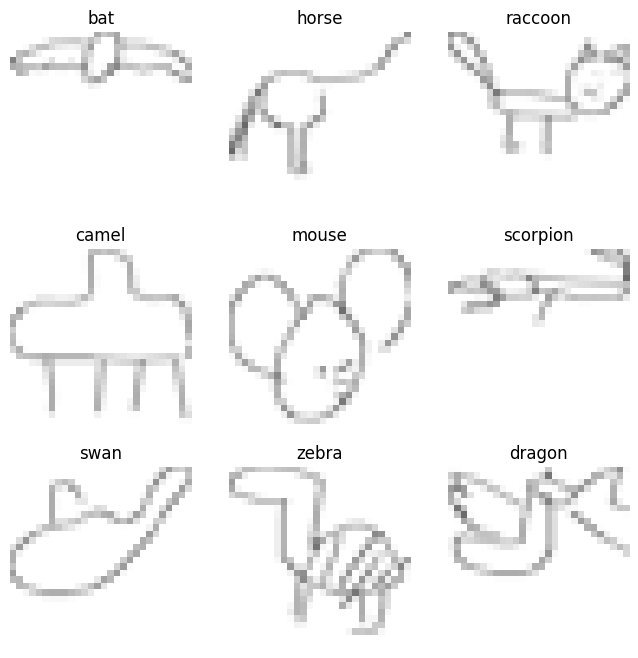

In [12]:
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        data = images[i].numpy().astype("uint8")
        plt.imshow(data, cmap='gray', vmin=0, vmax=255)
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

In [13]:
n_classes = len(animals)
input_shape = (28, 28, 1)

model = keras.Sequential([
    layers.Rescaling(1. / 255, input_shape=input_shape),
    layers.BatchNormalization(),

    layers.Conv2D(6, kernel_size=(3, 3), padding="same", activation="relu"),
    layers.Conv2D(8, kernel_size=(3, 3), padding="same", activation="relu"),
    layers.Conv2D(10, kernel_size=(3, 3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),

    layers.Dense(700, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(500, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(400, activation="relu"),
    layers.Dropout(0.2),

    layers.Dense(n_classes, activation="softmax")
])

In [14]:
epochs = 14

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt)

In [15]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback]
)

model.save('./models/model_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

Epoch 1/14
1200/1200 [==============================] - 28s 11ms/step - loss: 3.1925 - val_loss: 4.5420
Epoch 2/14
1200/1200 [==============================] - 13s 11ms/step - loss: 2.5864 - val_loss: 2.2819
Epoch 3/14
1200/1200 [==============================] - 15s 12ms/step - loss: 2.3584 - val_loss: 2.1800
Epoch 4/14
1200/1200 [==============================] - 15s 12ms/step - loss: 2.2693 - val_loss: 2.0164
Epoch 5/14
1200/1200 [==============================] - 15s 12ms/step - loss: 2.2156 - val_loss: 2.0605
Epoch 6/14
1200/1200 [==============================] - 15s 12ms/step - loss: 2.1706 - val_loss: 2.0044
Epoch 7/14
1200/1200 [==============================] - 14s 11ms/step - loss: 2.0827 - val_loss: 1.9088
Epoch 8/14
1200/1200 [==============================] - 15s 12ms/step - loss: 1.9971 - val_loss: 1.8819
Epoch 9/14
1200/1200 [==============================] - 13s 11ms/step - loss: 1.9645 - val_loss: 1.8759
Epoch 10/14
1200/1200 [==============================] - 15s 12m